In [1]:
%pylab inline
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)

Populating the interactive namespace from numpy and matplotlib


# Estimation of a seepage body

This example brings together different aspects of direct runoff generation and local flood control. Imagine a local depression with a building, some sealed areas (like parking lot and ways) and grassland. Since there is a tendency of flooding during heavy rainfalls in the depression, a seepage body shall be constructed.

It shall be large enough to store the 5-year maximum rainfall event of the area. Moreover, the seepage interface shall be at minimum capable to transport the 14-day maximum rainfall (with full storage and 14 days time to do so).

The reference area is 1100 m2. 120 m2 is the area covered by the building. 200 m2 are sealed. The remaining is grassland on a loamy soil. The field capacity of the soil is at 0.4 m3/m3, saturation at 0.58 m3/m3 volumetric soil water content. For the infiltration excess, the top 15 cm of the soil shall be considered. The seepage from the body is on average 2.3e-6 m/s 

## Precipitation time series and extreme value statistics

We read a time series of hourly precipitation at a nearby station. This is aggregated to daily sums.

In [2]:
usel=pd.read_csv('Useldange_Meteo_0815.csv',sep=';',skiprows=5)
usel.index=pd.to_datetime(usel.Tag_Stunde,format='%d.%m.%Y-%H')

In [3]:
uselP = usel.SUM_NN050.copy()

Text(0,0.5,'mm/d')

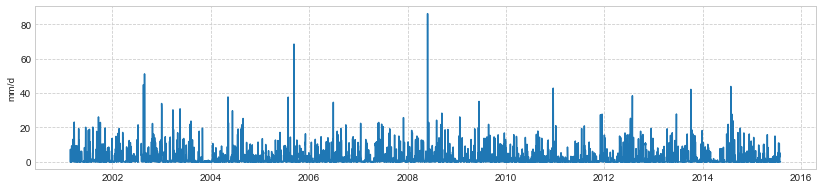

In [4]:
figsize(14,3)
plot(uselP.resample('1d').sum())
ylabel('mm/d')

In [5]:
# length of the time series in years
len(uselP)/(24*365)

14.328424657534246

Now we calculate the maximal daily precipitation of each year, sort the values and plot them agains the undercut propability (Pu). Since the 5-year maximum shall serve as reference, the corresponding Pu is 0.8 

We have annual extremes. If we seek to represent the 2-year extreme, this would correspond to Pu=0.5, meaning that every second event is below the reference value. A 5-year reference is hence at Pu = 0.8 partitioning the sample into 5 bins of 0.2 and cutting of the largest bin...

Text(0.5,0,'Pu')

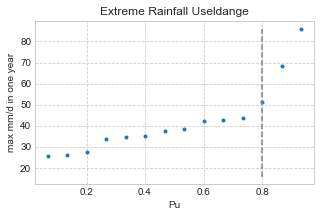

In [6]:
figsize(5,3)
N=len(uselP.resample('A').max())-1
Pu=(np.arange(N)+1)/(N+1)
ts=uselP.resample('1d').sum().resample('A').max()
plot(Pu, ts.sort_values(ascending=True).values[1:],'.')

pux=0.8
plot([pux,pux],[ts.min(),ts.max()],'--',c='grey')

title('Extreme Rainfall Useldange')
ylabel('max mm/d in one year')
xlabel('Pu')
#savefig('P_max_usel.pdf',bbox_inches='tight')

In [7]:
#annuality check
1/(1-pux)

5.000000000000001

In [8]:
#reference precipitation [mm]
Pref = ts.sort_values(ascending=True).values[np.where(Pu>pux)[0][0]]
Pref

51.100000000000001

In [9]:
#empty storage in the soil before saturation
S_soil = 0.18 * 0.15 #difference of soil water content at FC and saturation (m)

#calculate volume seepage body by the volume of direct runoff
A_sealed=320.          #area sealed
A_grass=1100.-A_sealed #area open land

Vqd_sealed=A_sealed*(Pref/1000)      #volume of direct runoff from sealed area with precipitation converted into meter
Vqd_grass=A_grass*(Pref/1000-S_soil) #volume of saturation excess runoff from grassland

Vstore = Vqd_sealed+Vqd_grass #total volume of direct runoff as target volume for the seepage body
Vstore

35.149999999999999

After knowing the target volume, lets calculate the minimal requirement for the seepage interface. An extreme rainfall event is not necessarily coming without any further events. As such we take the 14-day sums as reference to build our extreme value statistics as above. Moreover we mark the 2-year reference (which means that we would allow our seepage body to not fulfill the requirement every two yeras).

Text(0.5,0,'Pu')

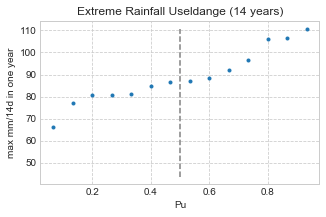

In [10]:
#Now check 14-day reference
N=len(uselP.resample('A').max())-1
Pu=(np.arange(N)+1)/(N+1)

ts=uselP.resample('14d').sum().resample('A').max()
plot(Pu, ts.sort_values(ascending=True).values[1:],'.')

pux=0.5
plot([pux,pux],[ts.min(),ts.max()],'--',c='grey')

title('Extreme Rainfall Useldange (14 years)')
ylabel('max mm/14d in one year')
xlabel('Pu')
#savefig('P_max_usel14.pdf',bbox_inches='tight')

In [11]:
#reference precipitation [mm]
Pref = ts.sort_values(ascending=True).values[np.where(Pu>pux)[0][0]]
Pref

86.700000000000003

Again, we can calculate the direct runoff of such an event to define the surplus to our projected seepage body:

In [12]:
Vqd_sealed=A_sealed*(Pref/1000)
Vqd_grass=A_grass*(Pref/1000-S_soil)

Vinfiltfromstore=Vqd_sealed+Vqd_grass-Vstore
Vinfiltfromstore

39.160000000000004

The given surplus volume of 39.16 m3 water shall infiltrate from the body at a given avarerage rate of 2.3e-6 m/s. As such we have to calculate the required seepage interface for this.

In [13]:
#per square metre we have an infitration of
k=2.3e-6

#that means a seepage per 14 days of ... in meter
Vs1 = 14*24*3600*k
Vs1

2.78208

In [14]:
# the seepage interface thus has to be ... square meter
Vinfiltfromstore/Vs1

14.075799401886359